# Notebook per eliminare picchi

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MinuteLocator, SecondLocator, DateFormatter
import pandas as pd
from numpy import loadtxt
pd.options.mode.chained_assignment = None  # default='warn'
import math

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm

## Celle da modificare prima di compilare

In [2]:
# Data e ora, azimuth

data_1 = '2023-04-19 '    # ricordarsi di lasciare spazio finale
data_2 = '2023-04-20 '    # data giorno successivo se puntamento si trova a cavallo tra due giorni
ora_i = '20:00:00'
ora_f = '22:56:00'
ora_m = '23:56:00'

azimuth = 105

In [3]:
# percorsi file

file_parabola = 'dati/TDA2023_04_19.txt'
file_ricevitore = 'dati/2023-04-19.txt'

In [4]:
zero_base = 4450

## Compilazione

In [5]:
azimuth_min = azimuth - 0.1
azimuth_max = azimuth + 0.1

data_i = pd.to_datetime(data_1 + ora_i, format = '%Y-%m-%d %H:%M:%S')
data_f = pd.to_datetime(data_1 + ora_f, format = '%Y-%m-%d %H:%M:%S')
data_m = pd.to_datetime(data_1 + ora_m, format = '%Y-%m-%d %H:%M:%S')

title = data_1 + ' azimuth: ' + str(azimuth)

In [6]:
# parametri calibrazione

S_azoto = -3.4884*zero_base + 26103.1305
err_s_azoto = 83.2899 + zero_base*0.0201

gamma = 0.7206836307034991
err_gamma = 0.007717044863009042

temp_azoto = 77.36
err_t_azoto = 0.22

In [7]:
# apertura file parabola e ricevitore e intervalli senza picchi

parabola = pd.read_csv (file_parabola,
                           sep=';',
                           header=None,
                           comment='#')

ricevitore_10 = pd.read_csv (file_ricevitore,
                                sep = ' ',
                                header=None,
                                skiprows=11,
                                decimal='.',
                                names=['data','ora','rad','temperatura'])

ora_intervalli = np.loadtxt("dati/ora_intervalli.txt", dtype= 'str')

In [8]:
parabola.rename(columns={0: 'day', 1: 'month', 2: 'year', 3: 'hour', 4: 'minute', 5: 'second', 9: 'azimuth', 10: 'elevazione'}, inplace = True)
parabola['data_ora'] = pd.to_datetime(parabola[["day", "month", "year", "hour", "minute", "second"]])
parabola = parabola.loc[:,['data_ora','elevazione','azimuth']]

In [9]:
ricevitore_10['data_ora'] = ricevitore_10['data'].map(str) + ' ' + ricevitore_10['ora'].map(str)
ricevitore_10['data_ora'] = pd.to_datetime(ricevitore_10['data_ora'], format = '%m/%d/%Y %H:%M:%S.%f')
ricevitore_10 = ricevitore_10.iloc[:,[-1,2,3]]

In [10]:
delta_time = pd.Timedelta(hours = 2)

In [11]:
mask_azimuth = (parabola.azimuth >= azimuth_min) & (parabola.azimuth <= azimuth_max)    # mask azimuth corretto

mask_ora_up = (parabola.data_ora >= data_i) & (parabola.data_ora <= data_m - delta_time)  # mask orario corretto fase salita

mask_ora_down = (parabola.data_ora >= data_m - delta_time) & (parabola.data_ora <= data_f)    # mask orario corretto fase discesa

In [12]:
grafico_totale = pd.DataFrame()

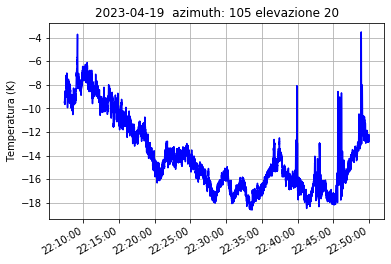

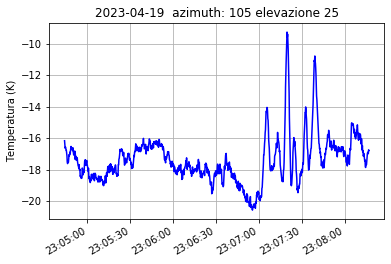

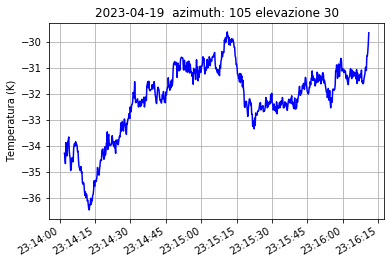

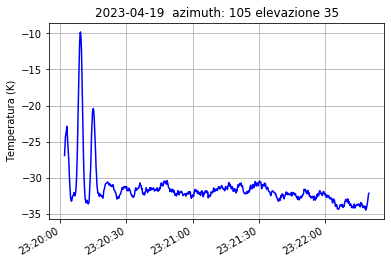

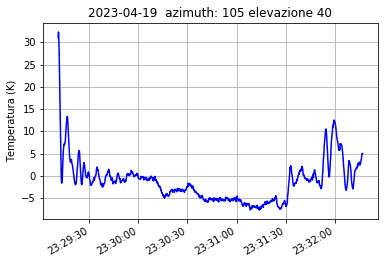

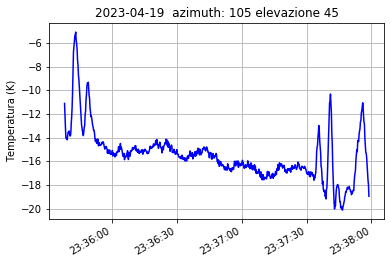

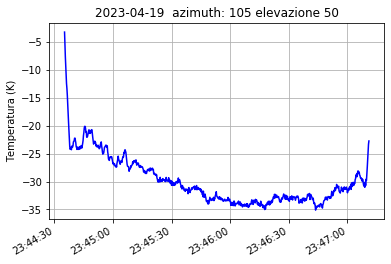

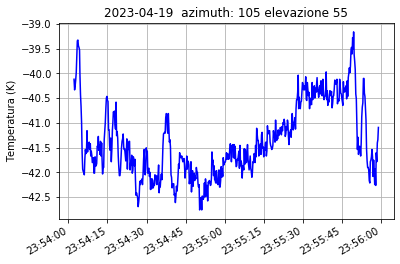

In [13]:
# salita

j = 0 # indice intervalli ritaglio
media_1 = []
err_1 = []


for i in range (20,56,5): 
    
    mask_elevazione = (parabola.elevazione >= i - 0.3) & (parabola.elevazione <= i + 0.3)   # mask elevazione

    up_parabola = parabola.loc[mask_azimuth & mask_elevazione & mask_ora_up]
    up_parabola.reset_index(inplace=True, drop=True)

    up_parabola['data_ora'] = up_parabola.data_ora + delta_time
    
    
    
    if (ora_intervalli[j] >= '21:00:00') & (ora_intervalli[j] <= '23:59:59.999'):
        data = data_1
    else: 
        data = data_2

    mask_intervalli = (up_parabola.data_ora >= data + ora_intervalli[j]) & (up_parabola.data_ora <= data + ora_intervalli[j+1])
    up_parabola = up_parabola.loc[mask_intervalli]

    mask_1 = ricevitore_10.data_ora >= up_parabola.iloc[0]['data_ora'] - delta_time
    mask_2 = ricevitore_10.data_ora <= up_parabola.iloc[-1]['data_ora'] - delta_time
    up_ricevitore_10 = ricevitore_10[mask_1 & mask_2]
    up_ricevitore_10['data_ora'] = up_ricevitore_10.data_ora + delta_time

    up_ricevitore_10.reset_index(inplace=True, drop=True)
    

    dev_up = up_ricevitore_10.rad.std()

    a = np.array((up_ricevitore_10.rad - S_azoto)/(84 * gamma))
    err_a = []

    num = np.array(up_ricevitore_10.rad - S_azoto)
    err_num = math.sqrt(dev_up**2 + err_s_azoto**2)

    den = 84 * gamma
    err_den = 84 * err_gamma

    for index in range(len(a)):
        err_a.append(a[index] * math.sqrt((err_num/num[index])**2 + (err_den/den)**2))

    T = temp_azoto
    err_T = err_t_azoto

    errore = []

    for indice in range(len(a)):
        errore.append(math.sqrt(err_a[indice]**2 + err_T**2))

    up_ricevitore_10.rad = ((up_ricevitore_10.rad - S_azoto)/(84 * gamma)) + 77.36
    up_ricevitore_10['errore'] = errore

    media_1.append(up_ricevitore_10.rad.mean())
    err_media_1 = math.sqrt(np.sum(up_ricevitore_10.errore**2))/len(up_ricevitore_10)

    err = up_ricevitore_10.rad.std()

    err_1.append(math.sqrt(err_media_1**2 + err**2))

    grafico_totale = pd.concat([grafico_totale, up_ricevitore_10])

    # grafici 

    fig, ax = plt.subplots()
    fig.autofmt_xdate()

    ax.plot(up_ricevitore_10['data_ora'],up_ricevitore_10['rad'], 'b', label='temp')
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))

    plt.title(title + ' elevazione ' + str(i))
    plt.ylabel('Temperatura (K)')
    plt.grid()

    j+=4

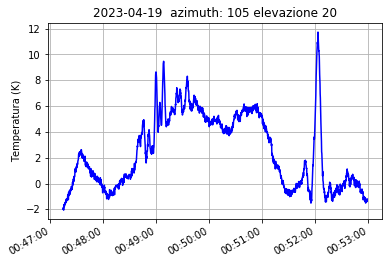

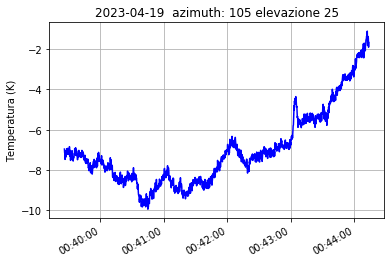

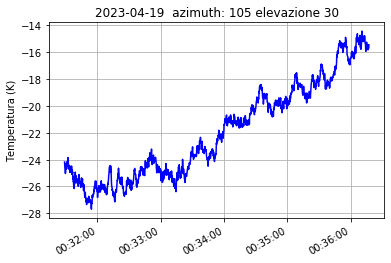

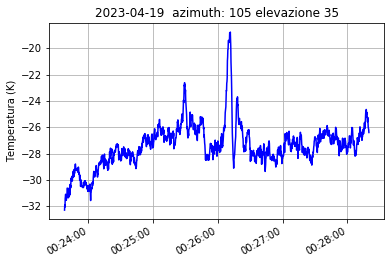

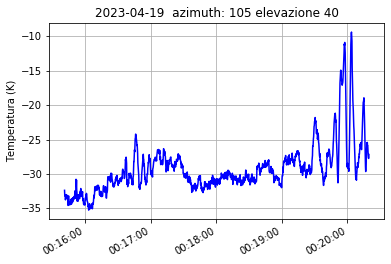

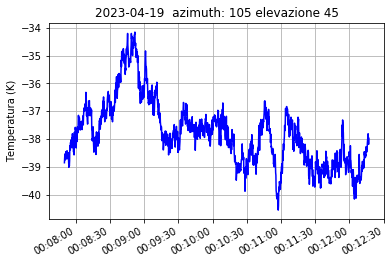

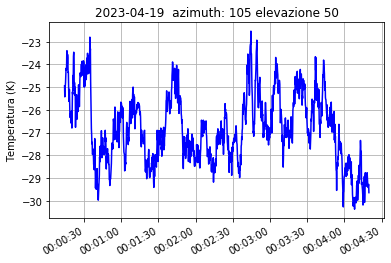

In [14]:
# discesa 

j = 0 # indice intervalli ritaglio
media_2 = []
err_2 = []

for i in range (20, 51, 5): # fase discesa

        mask_elevazione = (parabola.elevazione >= i - 0.3) & (parabola.elevazione <= i + 0.3)   # mask elevazione
        
        down_parabola = parabola.loc[mask_azimuth & mask_elevazione & mask_ora_down]
        down_parabola.reset_index(inplace=True, drop=True)

        down_parabola['data_ora'] = down_parabola.data_ora + delta_time

        if (ora_intervalli[j+2] >= '21:00:00') & (ora_intervalli[j+2] <= '23:59:59.999'):
                data = data_1
        else: 
                data = data_2

        mask_intervalli = (down_parabola.data_ora >= data + ora_intervalli[j+2]) & (down_parabola.data_ora <= data + ora_intervalli[j+3])
        down_parabola = down_parabola.loc[mask_intervalli]

        mask_3 = ricevitore_10.data_ora >= down_parabola.iloc[0]['data_ora'] - delta_time
        mask_4 = ricevitore_10.data_ora <= down_parabola.iloc[-1]['data_ora'] - delta_time
        down_ricevitore_10 = ricevitore_10[mask_3 & mask_4]
        down_ricevitore_10['data_ora'] = down_ricevitore_10.data_ora + delta_time

        dev_down = down_ricevitore_10.rad.std()

        a = np.array((down_ricevitore_10.rad - S_azoto)/(84 * gamma))
        err_a = []

        num = np.array(down_ricevitore_10.rad - S_azoto)
        err_num = math.sqrt(dev_down**2 + err_s_azoto**2)

        den = 84 * gamma
        err_den = 84 * err_gamma

        for index in range(len(a)):
                err_a.append(a[index] * math.sqrt((err_num/num[index])**2 + (err_den/den)**2))

        T = temp_azoto
        err_T = err_t_azoto

        errore = []

        for indice in range(len(a)):
                errore.append(math.sqrt(err_a[indice]**2 + err_T**2))

        down_ricevitore_10.rad = ((down_ricevitore_10.rad - S_azoto)/(84 * gamma)) + 77.36
        down_ricevitore_10['errore'] = errore

        media_2.append(down_ricevitore_10.rad.mean())
        err_media_2 = math.sqrt(np.sum(down_ricevitore_10.errore**2))/len(down_ricevitore_10)

        err = down_ricevitore_10.rad.std()
        err_2.append(math.sqrt(err_media_2**2 + err**2))

        grafico_totale = pd.concat([grafico_totale, down_ricevitore_10])
        
        # grafici

        fig, ax = plt.subplots()
        fig.autofmt_xdate()

        ax.plot(down_ricevitore_10['data_ora'],down_ricevitore_10['rad'], 'b', label='temp')
        ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))

        plt.title(title + ' elevazione ' + str(i))
        plt.ylabel('Temperatura (K)')
        plt.grid()

        j+=4

In [15]:
x = [-70,-65,-60,-55,-50,-45,-40,-35]
y = [35,40,45,50,55,60,65]

# trasformo in radianti

x = [(valore*np.pi)/180 for valore in x]
y = [(valore*np.pi)/180 for valore in y]
z = (0.3*np.pi)/180

tot = []

for i in range(0,len(media_1), 1): 
    tot.append([x[i],media_1[i],z,err_1[i]])

for i in range(0,len(media_2), 1): 
    tot.append([y[i],media_2[len(media_2)-1 -i],z,err_2[len(media_2)-1-i]])

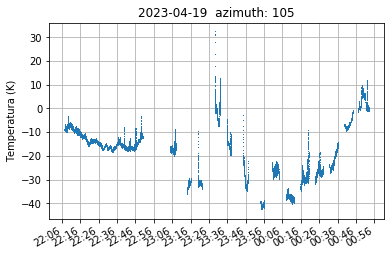

In [16]:
# grafico totale senza picchi

fig, ax = plt.subplots()
fig.autofmt_xdate()

ax.plot(grafico_totale['data_ora'],grafico_totale['rad'], ',', label='temp')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(MinuteLocator(interval = 10))

plt.title(title)
plt.ylabel('Temperatura (K)')
plt.grid()

Text(0.5, 1.0, 'Grafico senza picchi')

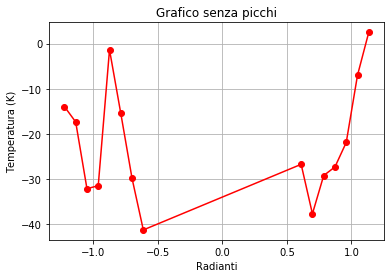

In [17]:
tot = pd.DataFrame(tot, columns= ['Elevazione', 'Temperatura', 'errore_elevazione','errore_temperatura'])

plt.plot(tot['Elevazione'], tot['Temperatura'], 'or-') 
plt.grid()
plt.ylabel('Temperatura (K)')
plt.xlabel('Radianti')
plt.title ('Grafico senza picchi')

In [18]:
np.savetxt('fit.txt', tot.values, fmt='%f')

## Fit

In [19]:
from scipy.optimize import curve_fit 
from mpmath import sec
from math import cos
from scipy.stats import chisquare

def model(x,a,b):
    return 250*a*1/np.cos(x) + b

tau_0 = 0.01
t_CMB = 3

best_fit,cov_matrix = curve_fit(model,tot['Elevazione'],
                                tot['Temperatura'],
                                p0=[tau_0,t_CMB])

In [20]:
for i in range(len(best_fit)):
    best_fit[i] = round(best_fit[i], 4)

In [21]:
p1 = 'tau_0 = ' +  str(best_fit[0]) + ' ± ' + str(round(cov_matrix[0,0]**0.5, 4))
p2 = 't_CMB = ' + str(best_fit[1]) + ' ± ' + str(round(cov_matrix[1,1]**0.5, 4))

93368995.24214812
0.0


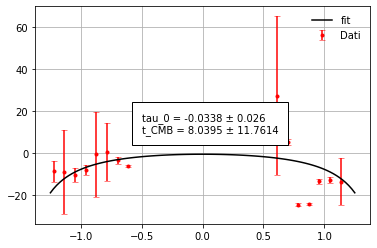

In [22]:
best_model = model(tot['Elevazione'],best_fit[0],best_fit[1])

xi = -1.25
xf = 1.25
n = 100

a = np.linspace(xi, xf, n)
b = model (a, best_fit[0], best_fit[1])

chi2 = np.sum(((np.array(tot['Temperatura']) - 250*best_fit[1]*1/np.cos([tot['Elevazione']]) + best_fit[0])/np.array(tot['errore_temperatura']))**2)
prob = stats.chi2.sf(chi2, 100) * 100  # calcolo probabilità chi quadro

print(chi2)
print(prob)


plt.errorbar(tot['Elevazione'], tot['Temperatura'], yerr=tot.errore_temperatura,
                fmt='.r', capsize=3, capthick=0.5, label= 'Dati') 
plt.plot(a,b,'black',zorder=3,label='fit')
plt.text(-0.5, 10, p1 + '\n' + p2 , fontsize=10, bbox ={'facecolor':'white', 'pad':10},  color='black')
plt.grid()
plt.legend(frameon=False)
plt.show()